# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [693]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.optim as optim
from random import randint
import statistics
import torch.distributions as tdist

In [694]:
def prepro(x):
    return torch.from_numpy(x).float()

In [766]:
class Policy_Net(nn.Module):
    def __init__(self):
        super(Policy_Net, self).__init__()
        self.l1 = nn.Linear(24,64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64,2)

    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))
        state = F.tanh(self.l3(state))
        return state

    
policy=Policy_Net()
optimizer = optim.Adam(policy.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 0.9999)

policy_1=policy
optimizer_1 = optim.Adam(policy.parameters(), lr=0.0001)


In [767]:
class Critic_Net(nn.Module):
    def __init__(self):
        super(Critic_Net, self).__init__()
        self.l1 = nn.Linear(48,128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128,2)

    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))
        state = F.tanh(self.l3(state))
        return state
    

value_function=Critic_Net()
optimizer_critic = optim.Adam(value_function.parameters(), lr=0.001)

In [768]:
def get_advantage(rewards, critic, states, l = .96):
  value_est = critic(states)
  value_est_0 = value_est[:-1]
  value_est_1 = value_est[1:]
  rewards = torch.tensor(rewards)
  advantage = rewards[:-1] + discount_rate * value_est_1 - value_est_0
  advantage = torch.cat((advantage,(rewards[-1]).view(1,2)))
  return advantage

In [769]:
def critic_loss(rewards, critic, states):
  value_est = critic(states)
  rewards = torch.tensor(rewards)
  return torch.mean((value_est-rewards)**2)

In [770]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount, epsilon, var, actor):

    rewards = rewards[:,actor].view(-1,1)
    # convert states to policy (or probability)
    new_total_probs = policy(states)
    dist = tdist.multivariate_normal.MultivariateNormal(new_total_probs, torch.eye(2) * var)
    new_probs = dist.log_prob(actions)

    ratio = torch.exp(new_probs-old_probs)
    
    clipped_loss = torch.where(ratio > torch.tensor(1+epsilon), torch.tensor(1+epsilon), ratio)
    clipped_loss = torch.where(clipped_loss < torch.tensor(1-epsilon),  torch.tensor(1-epsilon), clipped_loss)
    clipped_loss = torch.min(ratio * rewards, clipped_loss * rewards)
    #return torch.mean(torch.clamp(new_probs/old_probs * rewards, 1-epsilon * rewards, 1+epsilon * rewards))

    
    return torch.mean(clipped_loss)


In [771]:
def collect_trajectories(env, policy, policy_1, Max_Time, var, training_mode = True):
  env_info = env.reset(train_mode=training_mode)[brain_name]
  s0 = prepro(env_info.vector_observations)
  states = list()
  actions = list()
  rewards = list()
  old_probs = list()

  states_1 = list()
  actions_1 = list()
  rewards_1 = list()
  old_probs_1 = list()
    
  
  for step in range(Max_Time):
    if 1 == 0:
      action = 0
    else:
      #Gets Action
      probs = policy((s0[0]-states_mean)/states_std)
      probs = tdist.multivariate_normal.MultivariateNormal(probs, torch.eye(2) * var)
    
                                                           
      probs_1 = policy_1((s0[1]-states_mean)/states_std)
      probs_1 = tdist.multivariate_normal.MultivariateNormal(probs_1, torch.eye(2) * var)
    
      action = probs.sample()
      action_1 = probs_1.sample()
                                                           
      probs = probs.log_prob(action)
      probs_1 = probs_1.log_prob(action_1)
                                                           
      #Does Action
    env_info = env.step((torch.stack((torch.clamp(action,-1,1),torch.clamp(action_1,-1,1)),0).detach().numpy()))[brain_name]           # send all actions to tne environment
    state = env_info.vector_observations         # get next state (for each agent)
    reward = env_info.rewards                         # get reward (for each agent)
    done = env_info.local_done       
    #Adds to experience
    state = prepro(state)
    if step > -1:
      states.append(s0[0])
      actions.append(action)
      rewards.append(reward)
      old_probs.append(probs)
                                                           
      states_1.append(s0[1])
      actions_1.append(action_1)
      rewards_1.append(reward)
      old_probs_1.append(probs_1)   
    s0 = state
    if np.any(done):
      break
  scores = deepcopy(rewards)
  discount_scores = torch.tensor(deepcopy(rewards))
  #rewards = torch.tensor(rewards)
  rewards = get_advantage(rewards, value_function,  torch.cat((torch.stack(states),torch.stack(states_1)),1))
  for i in reversed(range(len(rewards)-1)):
    rewards[i] += discount_rate *0.95* rewards[i + 1]
    discount_scores[i] += discount_rate  * discount_scores[i+1]
    #if len(advantage_rewards[-1][i:]) > horizon_len:
    #  advantage_rewards[-1][i] += -1 *  advantage_rewards[-1][i + horizon_len - 1] * discount**horizon_len 
  #advantage_rewards[-1] = advantage_rewards[-1][:-horizon_len]   
  rewards = deepcopy(discount_scores)
  return old_probs, old_probs_1, states, states_1, actions, actions_1, rewards, scores, discount_scores

In [ ]:
import numpy as np

episode = 10000
discount_rate = .99
epsilon = 1.0
var = 1.0
tmax = 1000
SGD_epoch = 10
SGD_epoch_2 = 30
num_traj = 50
batch_size = 32

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    train_var = var
    old_probs, old_probs_1, states, states_1, actions, actions_1, rewards, scores, discount_scores = list(),list(),list(), list(), list(), list(), torch.tensor(list()) ,list(), torch.tensor(list())
    for traj in range(num_traj):
      old_probs_, old_probs_1_, states_, states_1_, actions_, actions_1_, rewards_, scores_, discount_scores_ = collect_trajectories(env, policy, policy_1, tmax, var)
      
      old_probs = old_probs + old_probs_
      states = states + states_       
      actions = actions + actions_
        
      old_probs_1 = old_probs_1 + old_probs_1_
      states_1 = states_1 + states_1_
      actions_1 = actions_1 + actions_1_

      rewards = torch.cat((rewards,rewards_))
      discount_scores = torch.cat((discount_scores,discount_scores_))
      scores = scores + scores_
      mean_rewards.append(np.max(sum(np.array(scores_))))
    #old_probs, states, actions, rewards, scores = collect_trajectories(env, policy, tmax)
        
    #Normalize Rewards
    

    states_mean = (torch.mean(torch.stack(states),0) + 3 * states_mean)/4
    states_std = (torch.std(torch.stack(states),0) + 3 * states_std)/4
    #states = (torch.stack(states)-states_mean)/(states_std+0.0000001)
    states = (torch.stack(states)-states_mean)/states_std
    #states_1_mean = torch.mean(torch.stack(states_1),0)
    #states_1_std = torch.std(torch.stack(states_1),0)
    #states_1 = (torch.stack(states_1)-states_1_mean)/(states_1_std+0.0000001)
    states_1 = (torch.stack(states_1)-states_mean)/states_std
    rewards_mean = 0
    rewards_std = 1
    rewards_mean = torch.tensor([torch.mean(rewards[:,0]),torch.mean(rewards[:,1])])
    rewards_std = torch.tensor([torch.std(rewards[:,0]),torch.std(rewards[:,1])])
    rewards = [(i-rewards_mean)/(rewards_std+0.0001) for i in rewards]

    total_rewards = np.sum(scores, axis=0)/num_traj
    
    actions = torch.stack(actions)
    old_probs = torch.tensor(old_probs)
    rewards = torch.stack(rewards)
    actions_1 = torch.stack(actions_1)
    old_probs_1 = torch.tensor(old_probs_1)

    
    # gradient ascent step
    for _ in range(SGD_epoch):
        
        permutation = torch.randperm(len(states))

        for i in range(0,len(states), batch_size):


            indices = permutation[i:i+batch_size]
            old_probs_batch, states_batch,actions_batch,rewards_batch = old_probs[indices], states[indices],actions[indices],rewards[indices]

            L = -clipped_surrogate(policy, old_probs_batch, states_batch, actions_batch, rewards_batch, discount_rate, epsilon, var, 0)

            optimizer.zero_grad()
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 3.0)
            optimizer.step()
            del L
        
    for _ in range(SGD_epoch):

        permutation = torch.randperm(len(states))

        for i in range(0,len(states), batch_size):


            indices = permutation[i:i+batch_size]
            old_probs_batch, states_batch,actions_batch,rewards_batch = old_probs_1[indices], states_1[indices],actions_1[indices],rewards[indices]

            L_1 = -clipped_surrogate(policy_1, old_probs_batch, states_batch, actions_batch, rewards_batch, discount_rate, epsilon, var, 1)

       

            optimizer_1.zero_grad()
            L_1.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy_1.parameters(), 3.0)
            optimizer_1.step()
            del L_1
    
    for _ in range(SGD_epoch_2):
        
        permutation = torch.randperm(len(discount_scores))
        
        for i in range(0,len(states), batch_size):
            indices = permutation[i:i+batch_size]
            states_1_batch, states_batch, scores_batch =  states_1[indices],states[indices],discount_scores[indices]

            # uncomment to utilize your own clipped function!
            L = critic_loss(scores_batch, value_function, torch.cat((states_batch,states_1_batch),1))

            optimizer_critic.zero_grad()
            L.backward()
            optimizer_critic.step()
            del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.9999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    if var > 0.2:
        var*=0.9995
    
    # get the average reward of the parallel environments
    
    # display some progress every 20 iterations
    if ((e+1)*num_traj)%50 ==0 :
        print("50 game average: {1:f}".format((e+1)*num_traj,np.mean(mean_rewards[-50:])))
        print(np.mean(mean_rewards))
        SGD_epoch_2 = 30
        if len(mean_rewards) > 200 and np.mean(mean_rewards[-100:]) >= 0.5:
            print('done')
            break
        

C:\Users\pmuralikrishnan\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


50 game average: 0.023800
0.023800000362098218
50 game average: 0.017000
0.02040000032633543
50 game average: 0.025000
0.021933333687484263
50 game average: 0.019800
0.02140000034123659
50 game average: 0.017400
0.020600000329315662
50 game average: 0.033400
0.02273333369443814
50 game average: 0.015000
0.021628571775342737
50 game average: 0.025000
0.022050000354647638
50 game average: 0.009600
0.020666666999459266
50 game average: 0.025400
0.021140000339597464
50 game average: 0.026800
0.02165454580363902
50 game average: 0.017600
0.021316667009765904
50 game average: 0.012000
0.020600000330461905
50 game average: 0.013600
0.020100000322397265
50 game average: 0.004000
0.019026666971544426
50 game average: 0.019400
0.01905000030528754
50 game average: 0.025400
0.019423529722673052
50 game average: 0.021600
0.01954444475678934
50 game average: 0.021200
0.019631579261469214
50 game average: 0.031200
0.020210000324994325
50 game average: 0.013600
0.019895238415116357
50 game average: 0.

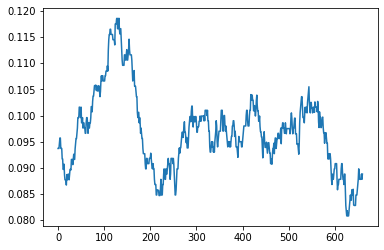

In [732]:
plt.plot([np.mean(mean_rewards[i:i+100]) for i in range(len(mean_rewards[:-100:]))])

In [737]:
var

0.1

In [765]:
#Running trained Agent
for i in range(5):
    old_probs_, old_probs_1_, states_, states_1_, actions_, actions_1_, rewards_, scores_,a = collect_trajectories(env, policy, policy_1, tmax, 0.001, training_mode=False)

In [629]:
states_1_batch[0]

tensor([-0.2128, -1.2912,  0.4544, -0.5880,  1.2794,  1.3196,  0.4544, -0.5880,
        -0.9202, -1.3651, -1.5929, -0.8868,  1.1796,  1.0772, -1.5929, -0.8868,
        -1.5168, -1.5654, -0.1508, -0.3401,  1.1283,  0.9233, -0.1508, -0.3401])

In [659]:
states_[0]

tensor([  6.2152, -30.0000,   5.9411,  -7.0216,   6.2152, -30.0000,  -0.9832,
        -10.2356,   0.0000,  -0.0000,   6.0000,  -7.0216,   0.0000,  -0.0000,
         -1.5000,  -7.2356,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000])

In [660]:
states_1_[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.1311, -1.5000,  0.0000,  0.0000,  7.0216,  6.0000,  0.0000,  0.0000,
        -6.0593, -0.9832,  0.7176,  6.2152,  7.0216,  5.9411,  0.7176,  6.2152])